In [23]:
%matplotlib inline

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec

Let's load the data as is

In [24]:
data = pd.read_csv('../data/train.csv')

Let's look at the variables

In [25]:
for col in data.columns:
    print(col)

url
timedelta
n_tokens_title
n_tokens_content
n_unique_tokens
n_non_stop_words
n_non_stop_unique_tokens
num_hrefs
num_self_hrefs
num_imgs
num_videos
average_token_length
num_keywords
data_channel_is_lifestyle
data_channel_is_entertainment
data_channel_is_bus
data_channel_is_socmed
data_channel_is_tech
data_channel_is_world
kw_min_min
kw_max_min
kw_avg_min
kw_min_max
kw_max_max
kw_avg_max
kw_min_avg
kw_max_avg
kw_avg_avg
self_reference_min_shares
self_reference_max_shares
self_reference_avg_sharess
weekday_is_monday
weekday_is_tuesday
weekday_is_wednesday
weekday_is_thursday
weekday_is_friday
weekday_is_saturday
weekday_is_sunday
is_weekend
LDA_00
LDA_01
LDA_02
LDA_03
LDA_04
global_subjectivity
global_sentiment_polarity
global_rate_positive_words
global_rate_negative_words
rate_positive_words
rate_negative_words
avg_positive_polarity
min_positive_polarity
max_positive_polarity
avg_negative_polarity
min_negative_polarity
max_negative_polarity
title_subjectivity
title_sentiment_polarity
a

_url_ and _timedelta_ are non predictive and _shares_ is our target.

From the dataset's description we know some of them are are expanded indicators like *weekday_is_weekdayname* variables and *data_channel_is_categoryname*, raw indicators, like *weekday_is_weekend*, integers, like word counts (there are several).

These are to be treated with caution or even remapped to other features.

How are *shares* distributed?

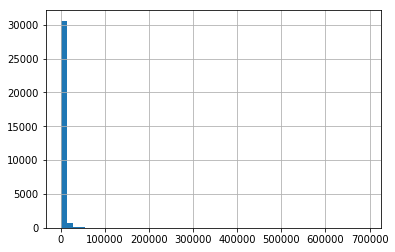

In [26]:
data['shares'].hist(bins=50)

Welp, that's no good. Let's try again but let's see where the cut is:

In [27]:
bins, intervals = np.histogram(data['shares'], bins=50)

last_i = 1
for (b, i) in zip(bins, intervals[1:]):
    print('%5d in range [%6d, %6d)' % (b, last_i, i))
    last_i = i


30599 in range [     1,  13808)
  734 in range [ 13808,  27616)
  168 in range [ 27616,  41424)
   83 in range [ 41424,  55232)
   42 in range [ 55232,  69040)
   26 in range [ 69040,  82848)
   13 in range [ 82848,  96656)
   16 in range [ 96656, 110464)
    7 in range [110464, 124272)
    3 in range [124272, 138080)
    6 in range [138080, 151888)
    1 in range [151888, 165696)
    0 in range [165696, 179504)
    1 in range [179504, 193312)
    5 in range [193312, 207120)
    3 in range [207120, 220928)
    1 in range [220928, 234736)
    0 in range [234736, 248544)
    0 in range [248544, 262352)
    0 in range [262352, 276160)
    0 in range [276160, 289968)
    1 in range [289968, 303776)
    2 in range [303776, 317584)
    0 in range [317584, 331392)
    0 in range [331392, 345200)
    0 in range [345200, 359008)
    0 in range [359008, 372816)
    0 in range [372816, 386624)
    0 in range [386624, 400432)
    0 in range [400432, 414240)
    0 in range [414240, 428048)
    1 in

The vanilla linear regressor accumulated a $10^8$ MSE. It may look like it's not converging but let's look that in depth.

The above distribution shows there are $\approx 30$ results that live in the $3 * 10^5$ range of shares. But linear models can't predict those ultra high shares (viral articles), so they stay inside their "mean" in the $10^3$s.

So the loss is a $3 * 10^5 - 10^3$ which is very near the $10^5$ anyway. Now to get the MSE we sum these $10^1$ values near $10^5$ to a $10^6$, square them getting a $10^12$ and divide by the size of the dataset, $10^12 / 10^5 = 10^7$.

Note note that $10^7 / 10^8 = 0.1$ which tells us we only need 10 share outliers in that magnitude to reach a $10^8$ error... and we have almost 30.

Let's cut the tail and see better what happens with the rest of the shares inside the first bin. No big deal, the remainder represents $3.52\%$ of the data

In [28]:
data_tail = data[data['shares'] > 13808]
data = data[data['shares'] <= 13808]

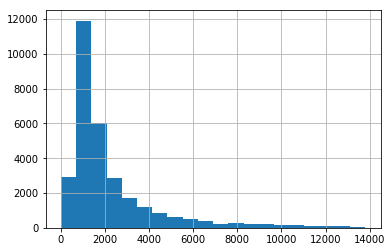

In [29]:
data['shares'].hist(bins=20)

That's about right. We still got the vast majority there between 0 and 2000 shares, so let's take a glimpse at that range and come back to reality:

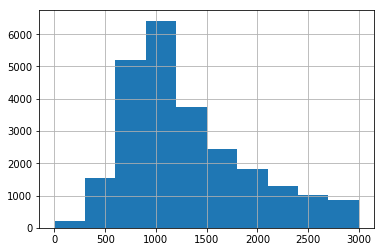

In [30]:
temp = data[data['shares'] <= 3000]['shares'].hist(bins=10)

Now we easily see most of articles are shared between 700 and maybe 1500 times. Let's look at the mean and standard deviation:

In [31]:
data[data['shares'] <= 3000]['shares'].describe()

count    24561.000000
mean      1330.998249
std        629.899695
min          1.000000
25%        861.000000
50%       1200.000000
75%       1700.000000
max       3000.000000
Name: shares, dtype: float64

And there you go, we still got $77\%$ of our data and $68\%$ of the shares are inside the interval $[700, 1960]$ 

Another good shot is to use percentiles to learn about the cut size in function of the amount of the dataset we want to keep. That's shown below:

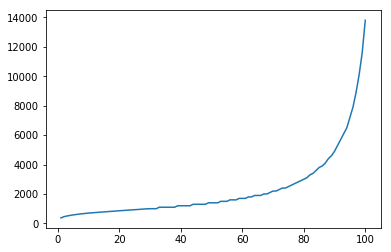

In [32]:
from scipy import percentile

a_hundred = np.arange(1, 101, 1)
percentiles = percentile(data['shares'], a_hundred)

plt.plot(a_hundred, percentiles)

Now on to some other questions. I'll be using this reduced dataset (no outliers, we will get to them later)

How many shares (mean and std) the articles have in total and how is this distributed inside each weekday?

count    30599.000000
mean      2226.959966
std       2226.340581
min          1.000000
25%        932.000000
50%       1400.000000
75%       2500.000000
max      13800.000000
Name: shares, dtype: float64


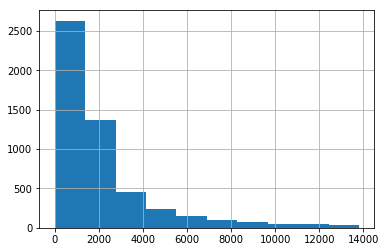

In [33]:
print(data['shares'].describe())

data[data['weekday_is_monday'] == 1]['shares'].hist(bins=10)

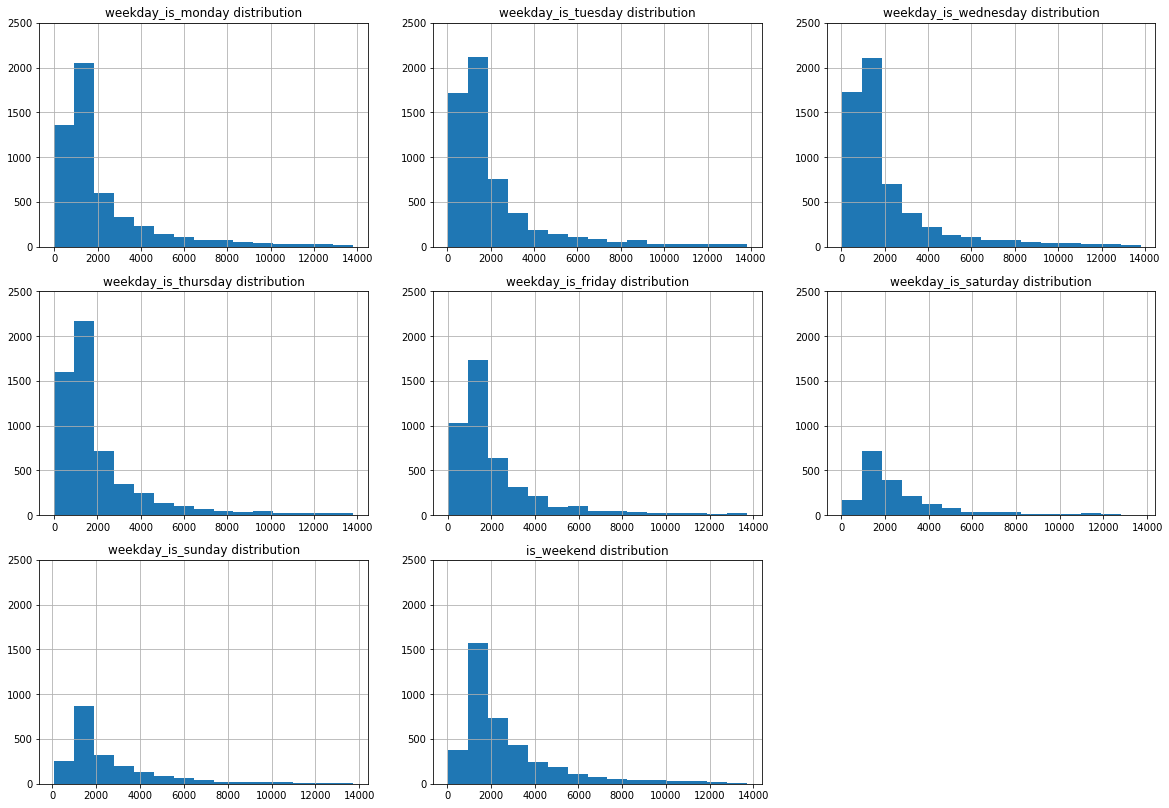

In [34]:
gs = GridSpec(3, 3)
axes = []
cols = ('weekday_is_monday', 'weekday_is_tuesday', 'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday', 'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend')
i = j = 0

fig = plt.figure(figsize=(20, 14))

for col in cols:
    sample = data[data[col] == 1]
    ax = plt.subplot(gs[i,j])
    
    ax.set_title(col + ' distribution')
    ax.set_ylim(0, 2500)
    
    sample['shares'].hist(bins=15, ax=ax)
    axes.append(ax)
    
    j = j + 1
    
    if j >= 3:
        j = 0
        i = i + 1

plt.show()        

First things first: nobody shares stuff in the weekend. Also: Friday is considered weekend because *reasons*.

Let's see how many articles were published per day, as we're already at it.

weekday_is_monday       5148.0
weekday_is_tuesday      5756.0
weekday_is_wednesday    5713.0
weekday_is_thursday     5632.0
weekday_is_friday       4386.0
weekday_is_saturday     1880.0
weekday_is_sunday       2084.0
is_weekend              3964.0
dtype: float64


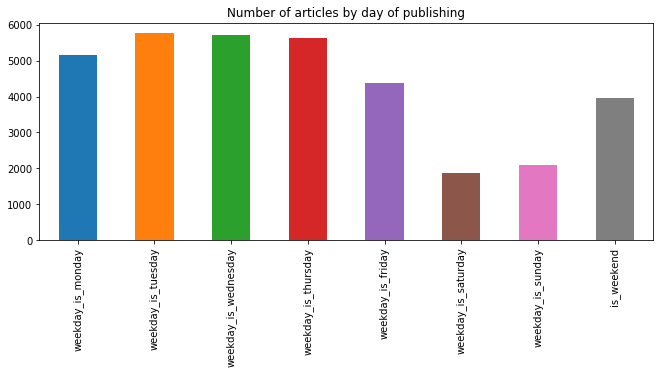

In [35]:
print(np.sum(data[np.asarray(cols)], axis=0))

np.sum(data[np.asarray(cols)], axis=0).plot(kind='bar', figsize=(11,4), title='Number of articles by day of publishing')

The same impression holds, and there is no apparent reason the day of the week has any impact on the distribution of shares.

Besides the observation on the weekend, of course, but even though they get less shares, their distribution resembles the distributions of the rest of the week days.

For the sake of sake, let's make a scaled version of this dataset and fit a `LinearRegression` object to it and look at the coefficients:

In [36]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

model = LinearRegression()
scaler = MinMaxScaler()

train_y = data['shares']
train_X = data.drop('shares', axis=1)

train_X.drop('url', axis=1, inplace=True)
train_X.drop('timedelta', axis=1, inplace=True)

train_X = pd.DataFrame(scaler.fit_transform(train_X), columns = train_X.columns)

model.fit(train_X, train_y)

for (col, w_i) in sorted(zip(train_X.columns, model.coef_), key=lambda x: x[1]):
    print('%30s: %3.3f' % (col, w_i))
    

             weekday_is_sunday: -5365117992616362.000
           weekday_is_saturday: -5365117992616336.000
           weekday_is_thursday: -853019876829102.125
            weekday_is_tuesday: -853019876829090.125
          weekday_is_wednesday: -853019876829071.000
             weekday_is_friday: -853019876828993.625
             weekday_is_monday: -853019876828956.000
              n_non_stop_words: -661198.272
                        LDA_04: -612484.791
                        LDA_01: -611790.962
                        LDA_03: -611579.319
                        LDA_02: -608020.203
                        LDA_00: -607189.650
      n_non_stop_unique_tokens: -289221.630
                    kw_max_avg: -25867.158
                    kw_avg_min: -9100.298
                num_self_hrefs: -2656.343
          average_token_length: -1817.925
    global_rate_negative_words: -904.984
                    kw_avg_max: -751.181
    self_reference_avg_sharess: -499.811
     global_sentiment_polar

Let's see what's the error of this linear fit we made:

In [37]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

test_X = pd.read_csv('../data/test.csv')
test_y = pd.read_csv('../data/test_target.csv')

test_X.drop(['url', 'timedelta'], axis=1, inplace=True)

predictions = model.predict(scaler.transform(test_X))

print('Test error for sklearn model is: %.3f' % (mse(test_y, predictions)))
print('Test error for sklearn model is: %.3f' % (mae(test_y, predictions)))

Test error for sklearn model is: 214422060.344
Test error for sklearn model is: 2629.560


Now the distribution of shares in test data.

              shares
count    7929.000000
mean     3519.839450
std     14638.795246
min         5.000000
25%       949.000000
50%      1400.000000
75%      2800.000000
max    843300.000000


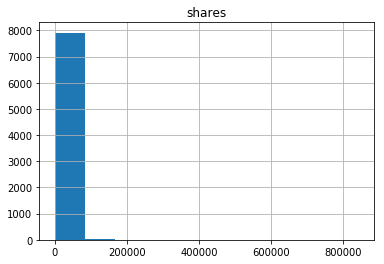

In [38]:
test_y.hist()

print(test_y.describe())

So the test **also** has outliers, or virals if you will.

My first shot dealing with this is to first drop some of the features then devise more complex models.

After all this, I'll try an ensemble: a classifier for the bulk data and another one for the tail, and something to glue them together.

But first, let's cut the test at the same point we did with the train earlier and see the overall distribution, comparing the two:

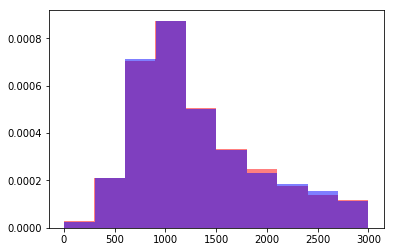

In [39]:
plt.figure()
plt.hist(data[data['shares'] <= 3000]['shares'], bins=10, density=True, alpha=0.5, color='r')
plt.hist(test_y[test_y['shares'] <= 3000]['shares'], bins=10, density=True, alpha=0.5, color='b')
plt.show()

Oooookay, that seems very balanced.

But are the tails?

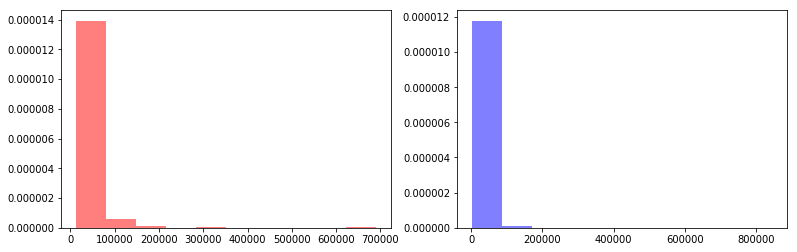

In [40]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
ax1.hist(data_tail[data_tail['shares'] > 3000]['shares'], bins=10, density=True, alpha=0.5, color='r')
ax2.hist(test_y[test_y['shares'] > 3000]['shares'], bins=10, density=True, alpha=0.5, color='b')
plt.show()

Hm, not so much. But who cares, train data has a broader sprectrum of share count, and test data appears to be entirely inside it.

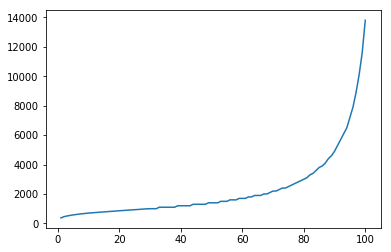

In [41]:
percentiles2 = percentile(train_y, a_hundred)

plt.plot(a_hundred, percentiles2)

Very similar plots than train_X's. No good.

Okay, let's see where does popularity lives, shall we?

In [42]:
data['shares'].describe()

count    30599.000000
mean      2226.959966
std       2226.340581
min          1.000000
25%        932.000000
50%       1400.000000
75%       2500.000000
max      13800.000000
Name: shares, dtype: float64

Let's answer a question: where are the biggest residuals?

Def: $residuals = predictions - actuals$

For this task, let's take that sklearn model we trained before

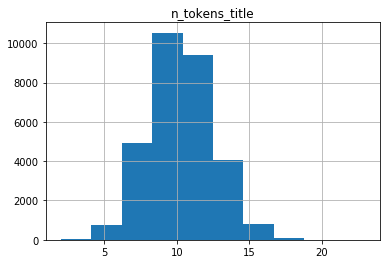

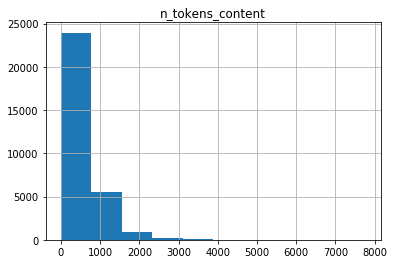

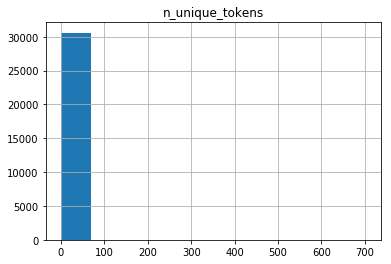

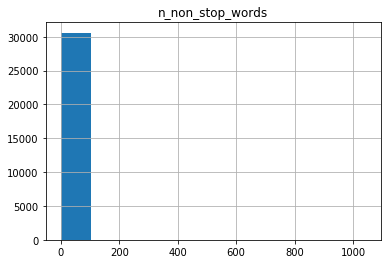

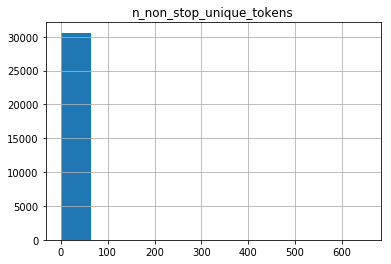

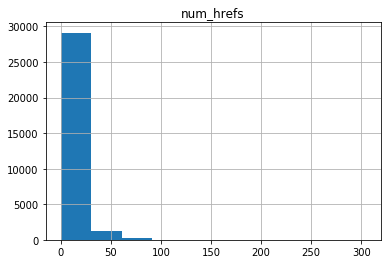

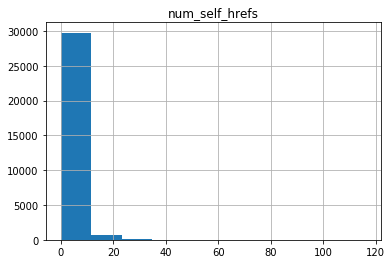

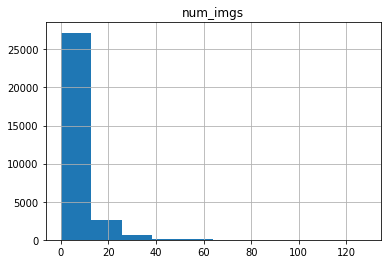

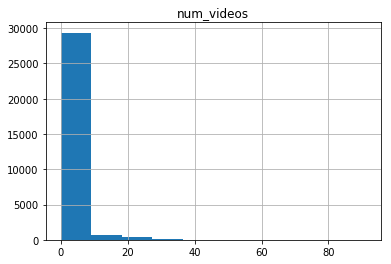

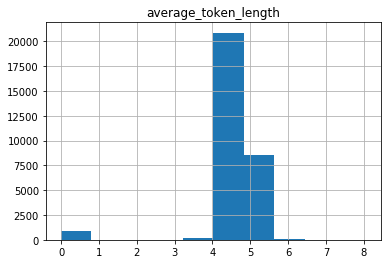

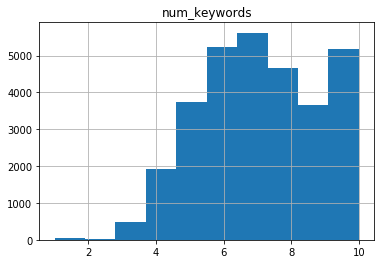

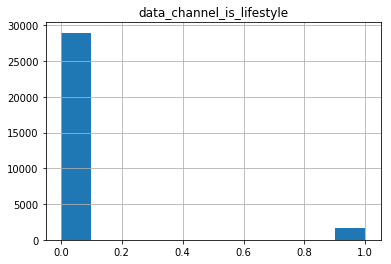

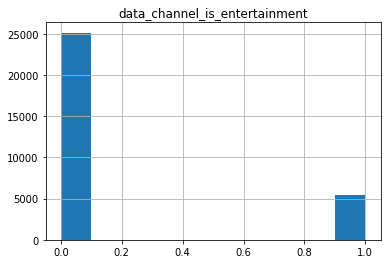

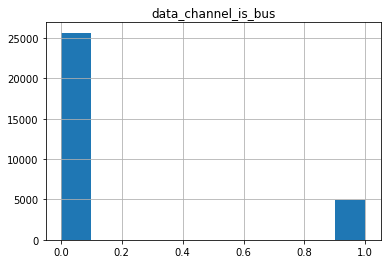

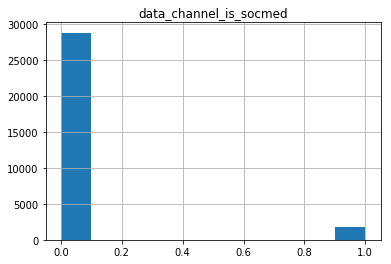

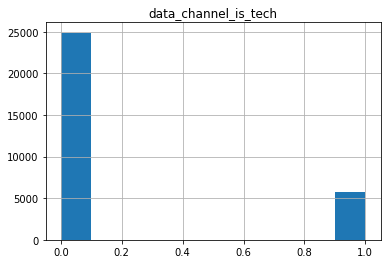

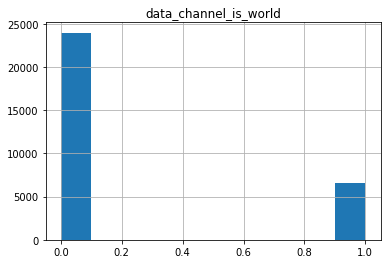

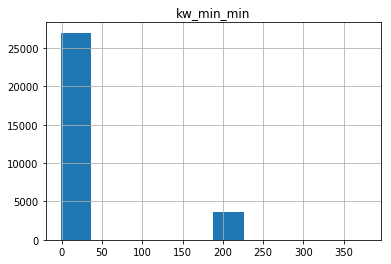

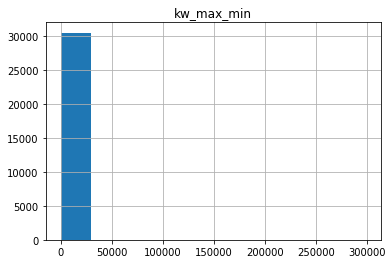

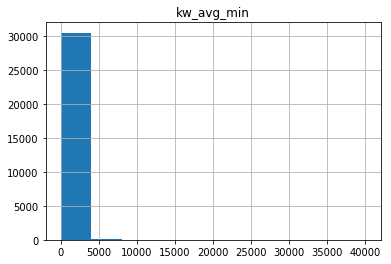

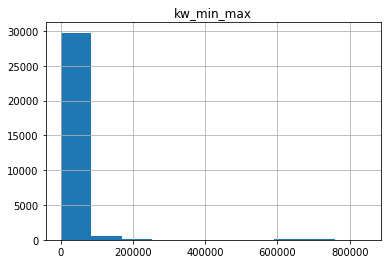

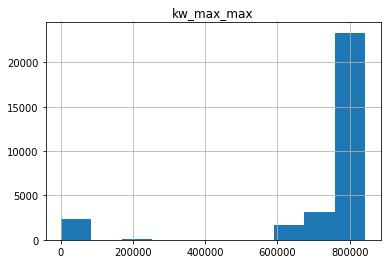

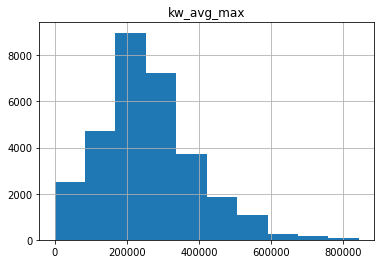

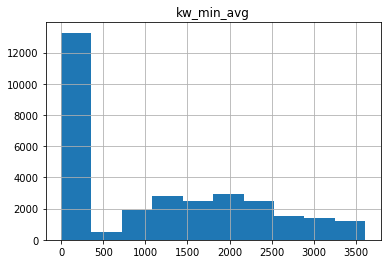

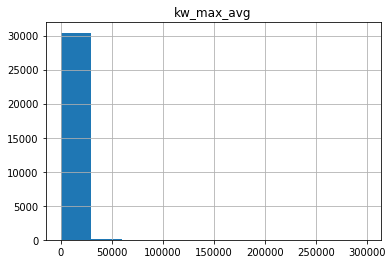

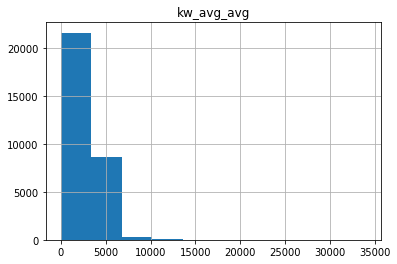

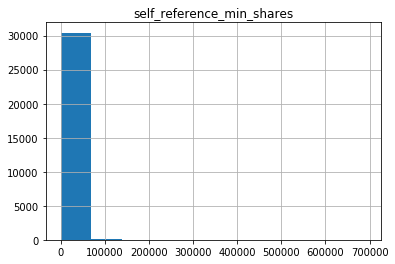

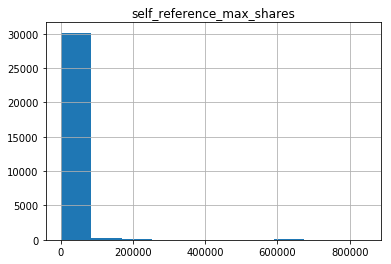

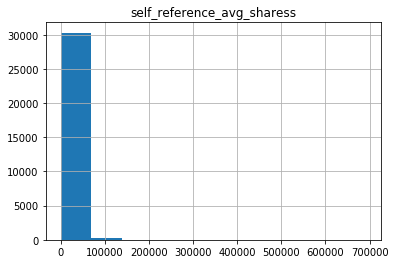

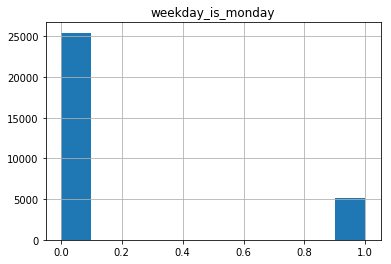

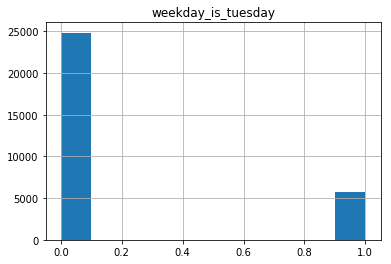

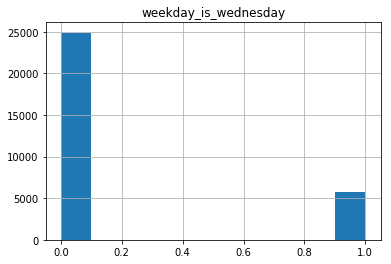

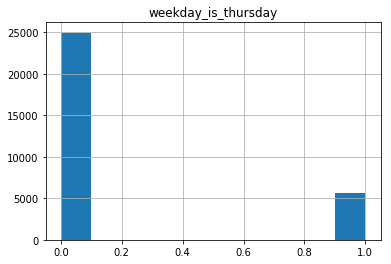

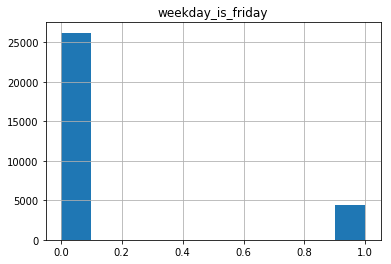

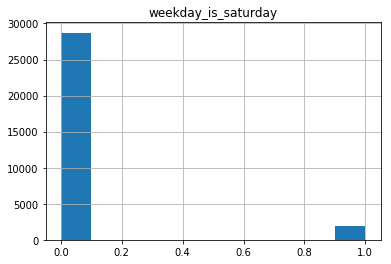

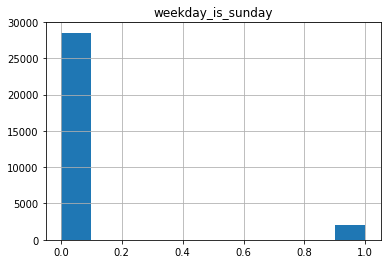

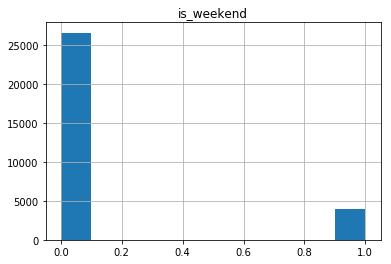

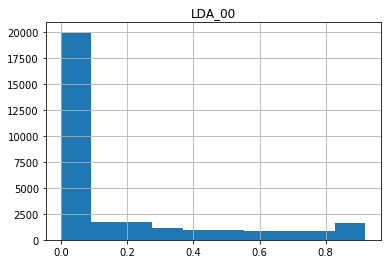

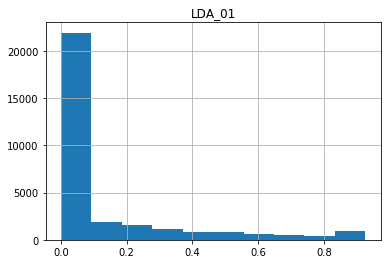

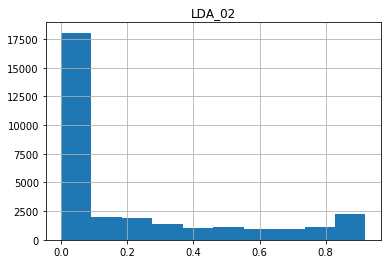

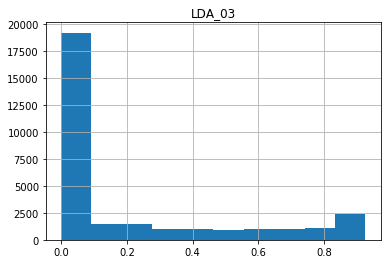

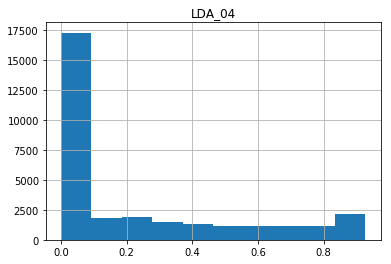

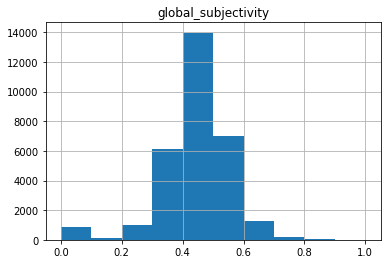

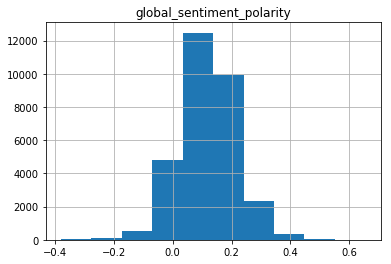

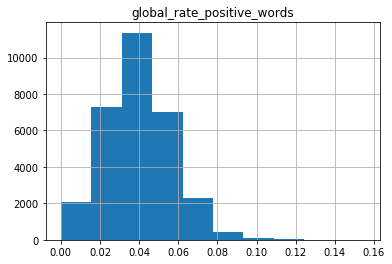

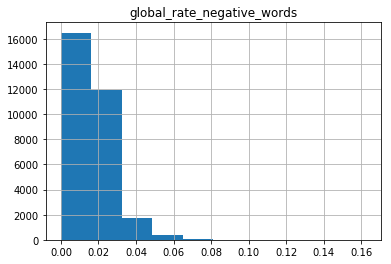

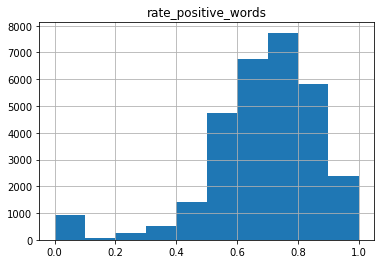

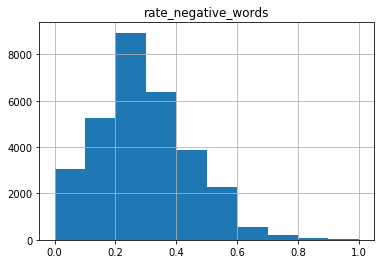

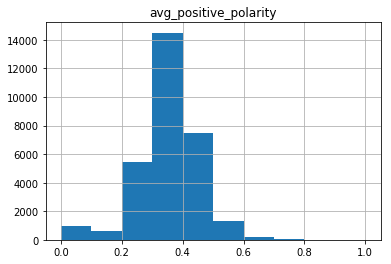

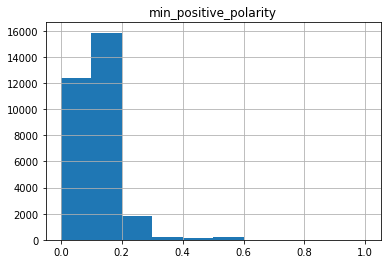

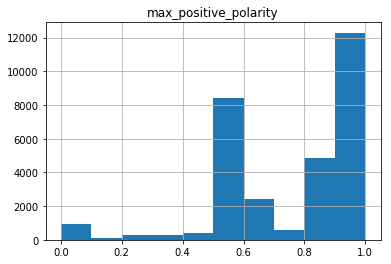

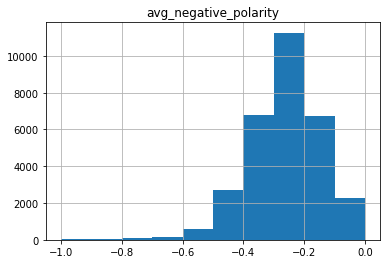

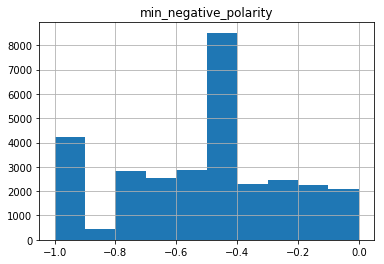

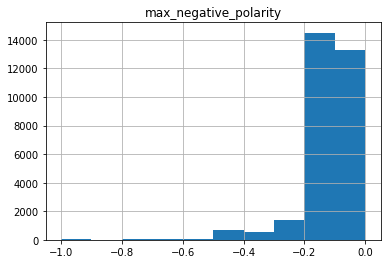

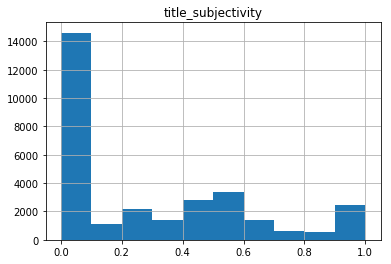

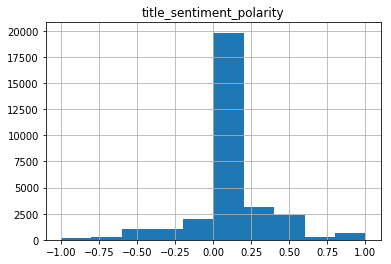

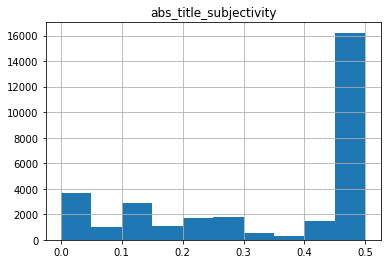

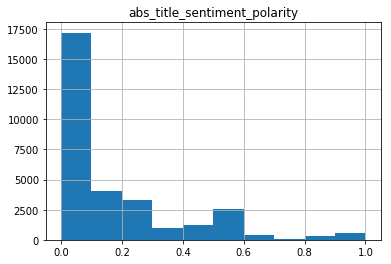

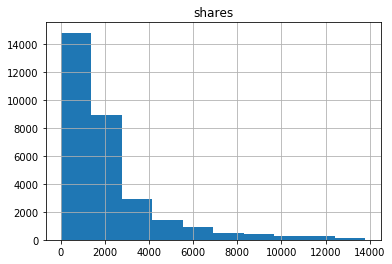

In [43]:
for col in data.drop(['url', 'timedelta'], axis=1).columns:
    data[col].hist(bins=10)
    plt.title(col)
    plt.show()

In [44]:
remove_outliers = [
    'n_tokens_content',
    'n_unique_tokens',
    'n_non_stop_words',
    'n_non_stop_unique_tokens',
    'num_hrefs',
    'num_self_hrefs',
    'num_imgs',
    'num_videos',
    'average_token_length',
    'kw_min_min',
    'kw_max_min',
    'kw_avg_min',
    #'kw_max_max',
    'kw_max_avg',
    'kw_avg_avg',
    'self_reference_min_shares',
    'self_reference_max_shares',
    'self_reference_avg_sharess',
]

feature_outliers = pd.DataFrame(columns=data.columns)

no_out_X = data

for col in remove_outliers:
    p = percentile(no_out_X[col], 99)
    
    feature_outliers = feature_outliers.append(no_out_X[no_out_X[col] > p])
    no_out_X = no_out_X[no_out_X[col] <= p]
    
print('done')


done


In [45]:
from sklearn.metrics import mean_absolute_error as mae

no_out_y = no_out_X['shares']
no_out_X.drop(['shares', 'url', 'timedelta'], axis=1, inplace=True)

model = LinearRegression()
scaler = MinMaxScaler()

no_out_X = scaler.fit_transform(no_out_X)
model.fit(no_out_X, no_out_y)

predictions = model.predict(scaler.transform(test_X))

print('Test error for sklearn model is: %.3f' % (mae(test_y, predictions)))

Test error for sklearn model is: 2683.755


In [46]:
from sklearn.metrics import mean_absolute_error as mae
print('Test error for sklearn model is: %.3f' % (mae(test_y, predictions)))

Test error for sklearn model is: 2683.755


In [52]:
feature_outliers.shape
25755 / data.shape[0]

0.84169417301219

Remove *weekday_is_saturday* and *weekday_is_sunday*, and aggregate monday-friday in a new variable *is_weekday*.

Now we have *is_weekday* and *is_weekend*.

This reduces the indicator variables which are not very good for regression methods.

I have to decide what to do w.r.t. *kw_w/e_w/e* and *w/e_w/e_polarity* variables.

They have both a min and a max but also an average, which encodes both information. Might be useless to keep all of them.

Now the outliers. Let's grab them and try to see if they have anything in common. In other words, let's try to predict if a given article will be viral.